In [44]:
#Import the libaries required to fully process the data set
import numpy as np
import pandas as pd
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#Data preperation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
#Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
#Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss


In [45]:
# Import the required data, it the Titanic data set 
data = pd.read_csv("titanic.csv")

In [46]:
#Inspect the imported dataset
data.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [47]:
#Check for any missing cells, the column(feature) data type,and the number of features and rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


There are no rows with missing cells or containing other text Charcters, there are 7 features and 887 rows of information
For this impported dataset produce descriptive statistics, which is very helpful for replacing any missing cells or outliers if contained in the dataset.

In [48]:
data.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


SPECIFICATION REVIEW
This is the time to review the project specification and establish what is required, what are the features of concern? are they numerical or catogoritical? 
This will inform the use of machine learning model, classification for categorical or regression for numbers. Some features can be converted to numerical type e.g. Sex as 0 and 1 etc. How much data is available? Is the required model supervised or unsuppervised or neural network? The work covers using the dataset for classification or prdiction not an analysis of the existing data.
The client had family members on board and is interested in what was the risk for a family at time of travel
So now the initial features of concern are:
1) Effect of passenger Sex and Age,
2) Did PClass matter?
3) How did children fair?
They dataset is small and the feature of interest (Survived) is already labeled leading to a model based on supervised learning 


Passenger names are not relevent for this study and names can introduce bias, so this column(feature) will be dropped from working dataset

DATA PREPERATION
So the outcome of the three above requirements is did the passenger surive
so this class(feature) of interest is already labeled as "Survived" in binary as 0 for died and 1 for survivied

In [49]:
#data['Survived'][:3]

In [50]:
#Names as mentioned above will be removed here
#Note new working file name
data1 = data.drop("Name",axis=1) #Its easier to get rid of the column than selecting it out later

In [51]:
#Sex is coded in text so now convert 'Sex' to binary female as 0 and male as 1
def str1_str2_mapper(string):
    if string == "male":
        return 1
    else:
        return 0

In [52]:
# Apply the above definition/function to the Sex column
data1["Sex"] = data[["Sex"]].applymap(str1_str2_mapper)
data1.head(3)

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250


Now Sex feature is numerical, Age is numerical, PClass is numerical and stiil need to count children, which is next action

In [53]:
#Initial test for age is a person under 18
count=0
passengers = data1[["Pclass","Age","Sex"]]
for i in range(len(passengers)):
    if passengers["Age"][i]<19:
        count=count+1
print("Number of children 18 years of age or less  ",count)

Number of children 18 years of age or less   166


In [54]:
#Initial test for age is a person under 18
count_fm=0;count_fm_p1=0;count_fm_p2=0;count_fm_p3=0
count_m=0;count_m_p1=0;count_m_p2=0;count_m_p3=0
num_females=[]
num_females_p1=[]
num_females_p2=[]
num_females_p3=[]
num_males=[]
num_males_p1=[]
num_males_p2=[]
num_males_p3=[]
#For box plots set up the parameters
#female and male by age
for i in range(len(passengers)):
    if passengers["Sex"][i]==0:
        count_fm=count_fm+1
        num_females.append(data1["Age"][i])
    if passengers["Sex"][i]==1:
        count_m=count_m+1
        num_males.append(data1["Age"][i])
    #Place females in each class
    if passengers["Pclass"][i]==1 and passengers["Sex"][i]==0:
        count_fm_p1=count_fm_p1+1
        num_females_p1.append(data1["Age"][i])   
    if passengers["Pclass"][i]==2 and passengers["Sex"][i]==0:
        count_fm_p2=count_fm_p2+1
        num_females_p2.append(data1["Age"][i])   
    if passengers["Pclass"][i]==3 and passengers["Sex"][i]==0:
        count_fm_p3=count_fm_p3+1
        num_females_p3.append(data1["Age"][i])  
    #Now deal with males
    if passengers["Pclass"][i]==1 and passengers["Sex"][i]==1:
        count_m_p1=count_m_p1+1
        num_males_p1.append(data1["Age"][i])   
    if passengers["Pclass"][i]==2 and passengers["Sex"][i]==1:
        count_m_p2=count_m_p2+1
        num_males_p2.append(data1["Age"][i])   
    if passengers["Pclass"][i]==3 and passengers["Sex"][i]==1:
        count_m_p3=count_m_p3+1
        num_males_p3.append(data1["Age"][i])             
        
#print(count_fm_p1)
#print(num_females_p1)

PLOTTING THE ABOVE CHOOSEN FEATURES FROM THE DATASET

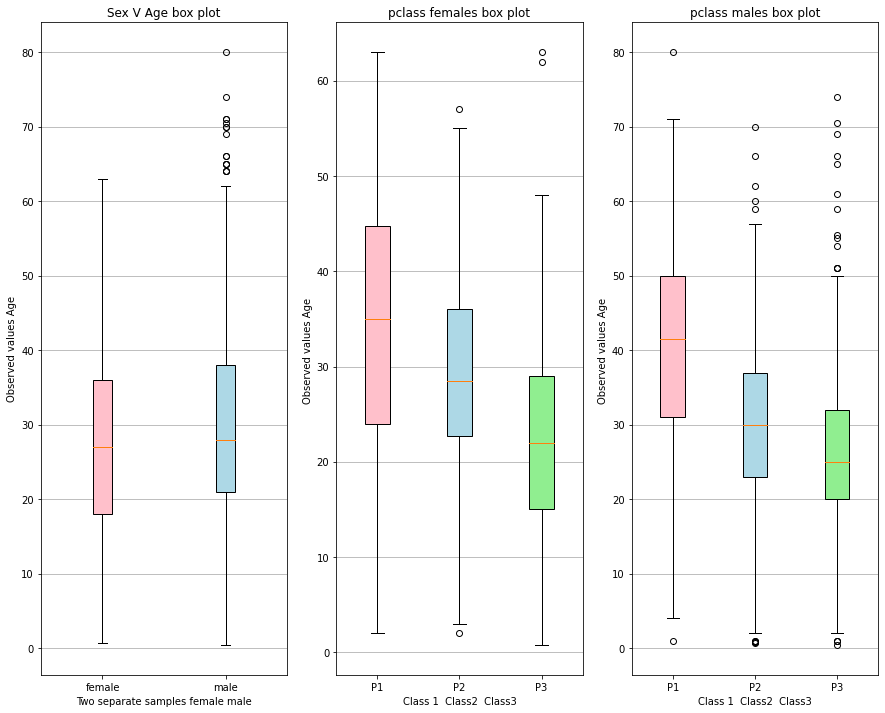

<Figure size 432x288 with 0 Axes>

In [55]:
labels = ['female', 'male']
labels2 = ['P1', 'P2', 'P3']
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 12))

# rectangular box plot
bplot1 = ax1.boxplot((num_females,num_males),
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Sex V Age box plot')

#Pclass, Age and Sex box plot
bplot2 = ax2.boxplot((num_females_p1,num_females_p2,num_females_p3),
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels2)  # will be used to label x-ticks
ax2.set_title('pclass females box plot')

bplot3 = ax3.boxplot((num_males_p1,num_males_p2,num_males_p3),
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels2)  # will be used to label x-ticks
ax3.set_title('pclass males box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2,bplot3):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Two separate samples female male')
    ax.set_ylabel('Observed values Age')
for ax in [ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Class 1  Class2  Class3')
    ax.set_ylabel('Observed values Age ')
for ax in [ax3]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Class 1  Class2  Class3')
    ax.set_ylabel('Observed values Age ')

plt.show()
plt.tight_layout()

Note, a lot of children are in P2 and P3 MALE


PREPARING THE DATA FOR MODELLING

In [56]:
#Select out the main numerical data from the data1 and rename
data2 = data1.values
#x will be made up of three features "Pclass", Age" and "Sex"
x = data2[0:,(1,2,3)]
#print(x)
#machine learning respondS best with scaled data,i.e. numbers between 0 and 1
#So rescale "Age"
x_scaler = MinMaxScaler()
x = x_scaler.fit_transform(x)
#Some Algorithms like the shape of the x variable preset
#Reshape x as three features
X = np.reshape(x, (-1,3))
#Check shape
X.shape

(887, 3)

In [57]:
#For a progress check, look at x, Pclass, Sex and Age
print(X)

[[1.         1.         0.27117366]
 [0.         0.         0.4722292 ]
 [1.         0.         0.32143755]
 ...
 [1.         0.         0.08268409]
 [0.         1.         0.32143755]
 [1.         1.         0.39683338]]


In [58]:
#Now generate y, they died or survived
y= data2[0:,(0)]
#y does not need reshaping as its only one feature
#check shape
y.shape

(887,)

MODELLING,
three algorithms will used and the one returning the most accurate result will then be choosen for more optimisation
The selection will be K Nearest Neighbors(knn), Support Vector Machine (SVM) and Dcision tree, there are others but these are the main ones for this study
(K Nearest Neighbors(knn), checked with seperate notbook returned the number of clusters as 4)
Then
Divide the datset into 90% train rows and 10% for testing against later


In [59]:
classifiers = [
    KNeighborsClassifier(4),
    SVC(),
    DecisionTreeClassifier()]

In [60]:
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)
#Divide up the dataset into train and test
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
acc_dict = {}

In [61]:
#Now applying the dataset split between train and test
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Run the three choosen classifiers and plot accuracy

In [62]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

<AxesSubplot:title={'center':'Classifier Accuracy'}, xlabel='Accuracy', ylabel='Classifier'>

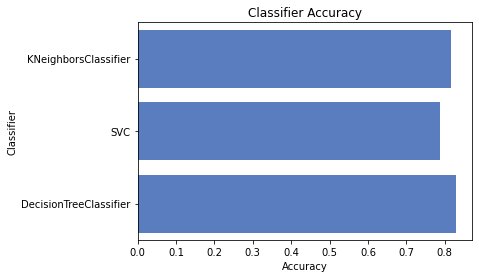

In [63]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

Now optimise the Decision Tree classifier,
above the Decision tree clasifier returned over 80%, now try optimising it, all hyperparametres were tested in a ordered manner
The improvement moved from initial 72% to now at 83% which appears to be at maximum. The hyprtparameters are listed in next line

In [64]:
#clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf_opt = DecisionTreeClassifier(criterion="gini", max_depth=None, max_leaf_nodes=None, random_state=None,splitter='best')
clf_opt.fit(X_train, y_train)

DecisionTreeClassifier()

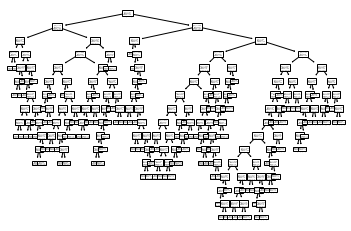

In [65]:
#Tree plot
tree.plot_tree(clf_opt)
plt.show()

Now test for improvement

In [66]:
y_pred = clf_opt.predict(X_test)

In [67]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8314606741573034


Trying Predictions Pclass, Sex,Age

In [68]:
y_pred = clf_opt.predict([[3,0,28]])

In [69]:
print(y_pred)

[1.]


In [70]:
#Predict against age
#Take care to understand if the model expects scaled inputs. Scaled inputs will be used
for j in range(5,100,5): #From 5 years to 100 in steps of 5 years
    y_pred=0
    y_pred = clf_opt.predict([[0.5,0,j/100]])
    print(j,y_pred)
    

5 [1.]
10 [1.]
15 [1.]
20 [1.]
25 [1.]
30 [1.]
35 [1.]
40 [1.]
45 [1.]
50 [1.]
55 [0.]
60 [1.]
65 [1.]
70 [0.]
75 [0.]
80 [0.]
85 [0.]
90 [0.]
95 [0.]


Conclusion
1) A suitable model was generated that on input of the three parameters a survival output decision is produced at 83% chance of being correct
2) The data entered centers on age, sex and Pclass, but there are confounding issues to beconsidered, e.g. family members most likely be in the same Pclass. Most children in P2 and P3
3) Any dataset with gender counts can lead to bias, no conclussions were drawn, let the data speak
4) Peoples names can imediately rise bias responses, so names were avoided as not required in this study
5) An accuracy of 83% was achieved, but care should be taken with an extended tree that overfitting has not crept in